In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import time
import json

from IPython import display

In [6]:
def get_processed_images(images, encoding_index=2):
  MAP_SIZE = 32
  train_size, x_dims, y_dims = images.shape
  z_dims = 13 # Number of different title types

  images_onehot = np.eye(z_dims, dtype='uint8')[images]
  images = np.zeros((train_size, MAP_SIZE, MAP_SIZE, z_dims))
  images[:, :, :, encoding_index] = 1.0  # Fill with empty space 
  images[:train_size, :x_dims, :y_dims, :] = images_onehot

  return images

In [7]:
def generate_level(gen_str, gen_color, n_iters, seedfile):
  cond_img = get_processed_images(np.array(json.load(open(seedfile)))[70:71])
  level = cond_img[:, :, 0:21, :]
  noise_size = 32
  random_vector_list = []

  for i in range(n_iters):
    random_vector = tf.random.normal([1, noise_size])
    random_vector_list.append(random_vector)
    structure_img = gen_str([cond_img, random_vector])
    structure_img = gen_str([cond_img, random_final[i]])
    color_img = gen_color(structure_img)
    level = np.concatenate((level, color_img[:, :, 21:28, :]), axis=2)
    cond_img = np.concatenate((cond_img[:, :, 7:21, :], get_processed_images(np.argmax(color_img, axis=3)[:, :, 21:28])[:, :, :18, :]), axis=2)

  return random_vector_list, np.argmax(level[0], axis=2)[:14,:]

In [8]:
generator_saved_structure = tf.keras.models.load_model('models/generator_structure_combined_alt2_5000')
generator_saved_color = tf.keras.models.load_model('models/generator_color_alt_5000')

In [16]:
random_vectors, output = generate_level(generator_saved_structure, generator_saved_color, 40, 'smb1_left_2.json')
output.shape

(14, 301)

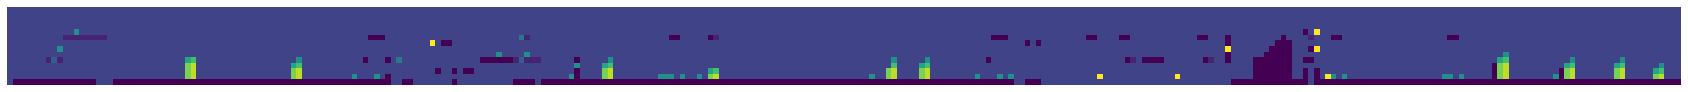

In [10]:
fig = plt.figure(figsize=(30, 10))

plt.imshow(output)
plt.axis('off')
plt.savefig('image.png')
plt.show()

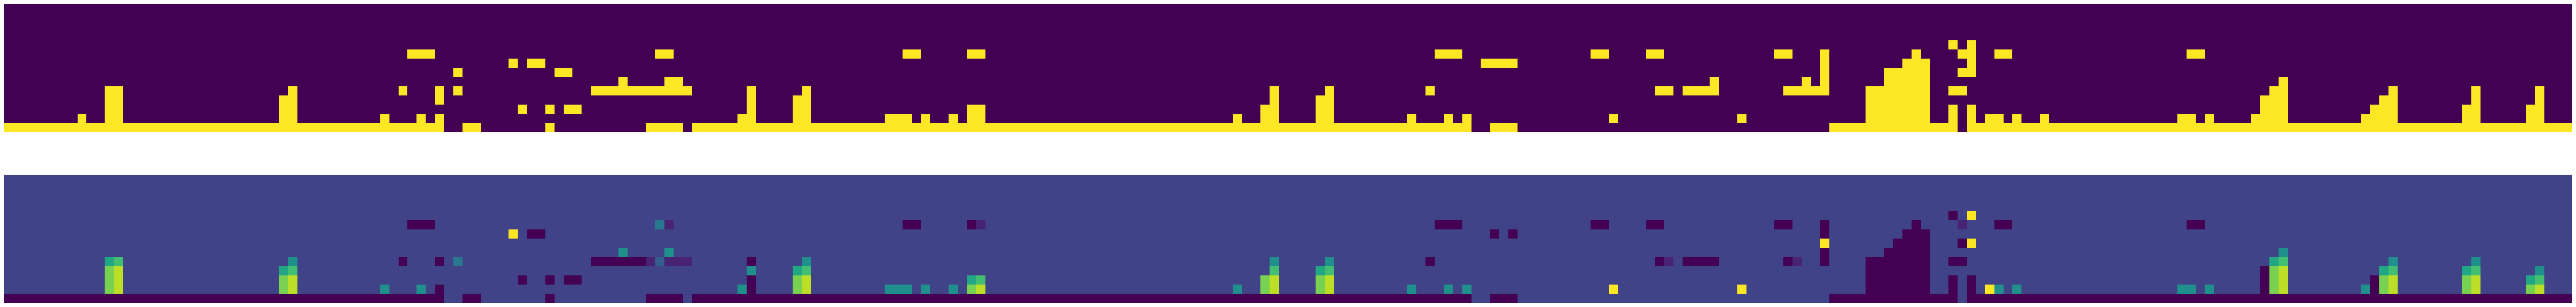

In [58]:
# Visualize MSGAN generation for demo
gen_str = generator_saved_structure
gen_color = generator_saved_color
n_iters = 40
seedfile = 'smb1_left_2.json'
random_vectors = random_final

cond_img = get_processed_images(np.array(json.load(open(seedfile)))[500:501])
level = None
level_structure = None
noise_size = 32

for i in range(n_iters):
  random_vector = random_vectors[i]
  structure_img = gen_str([cond_img, random_vector])
  color_img = gen_color(structure_img)
  if level is None:
    level = color_img[:, :, 21:28, :]
    level_structure = structure_img[:, :, 21:28, :]
  else:
    level = np.concatenate((level, color_img[:, :, 21:28, :]), axis=2)
    level_structure = np.concatenate((level_structure, structure_img[:, :, 21:28, :]), axis=2)
  cond_img = np.concatenate((cond_img[:, :, 7:21, :], get_processed_images(np.argmax(color_img, axis=3)[:, :, 21:28])[:, :, :18, :]), axis=2)
  
  display.clear_output(wait=True)

  fig = plt.figure(figsize=(80, 10))
  plt.subplot(2, 1, 1)
  plt.imshow(np.argmax(level_structure[0], axis=2)[:14,:])
  plt.axis('off')

  plt.subplot(2, 1, 2)
  plt.imshow(np.argmax(level[0], axis=2)[:14,:])
  plt.axis('off')

  plt.show()

  time.sleep(.5)

In [2]:
from image_gen.image_gen import GameImageGenerator

In [17]:
from PIL import Image

base_path = "drive/MyDrive/image_gen/image_gen/data/mario_assets/encoding_{}.png"
asset_map = {}
for i in range(11):
    try:
        asset_map[i] = Image.open(base_path.format(i))
    except FileNotFoundError:
        continue
image_gen = GameImageGenerator(asset_map=asset_map)
image_gen.render(image_array=output2, sprite_dims=(16, 16))